In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"riship3499","key":"f05439e4bf2d33cd99322d4f479bfb47"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data


Dataset URL: https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data
License(s): CC0-1.0
  0% 0.00/2.44M [00:00<?, ?B/s]
100% 2.44M/2.44M [00:00<00:00, 212MB/s]


In [4]:
import zipfile
with zipfile.ZipFile("new-york-city-airbnb-open-data.zip", 'r') as zip_ref:
    zip_ref.extractall("airbnb_data")


In [7]:
import pandas as pd
df = pd.read_csv("airbnb_data/AB_NYC_2019.csv")  # Adjust the filename if different


Basic EDA

In [6]:
# Display the first few rows
print(df.head())

# Get an overview of data types and missing values
print(df.info())

# Summary statistics for numerical columns
print(df.describe())


     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  20

In [8]:
# Calculate the percentage of missing values per column
missing_values = df.isnull().mean() * 100
print(missing_values[missing_values > 0])


name                 0.03
host_name            0.04
last_review         20.56
reviews_per_month   20.56
dtype: float64


Visualizations

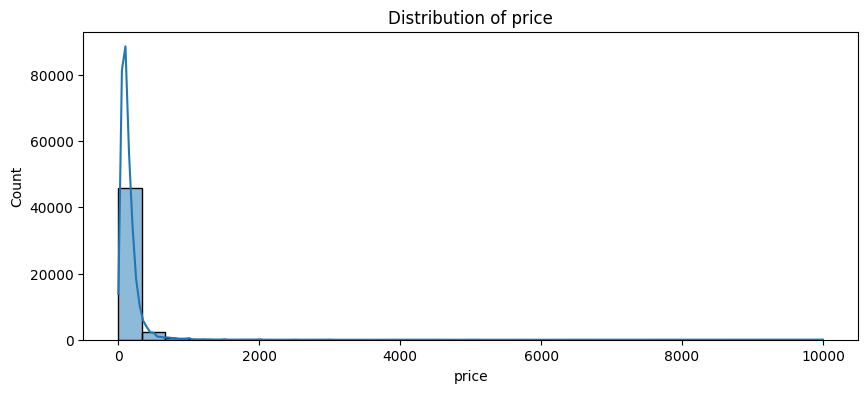

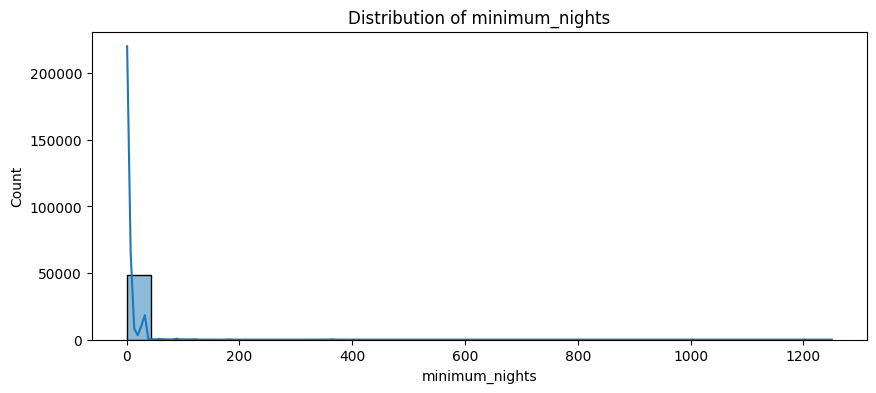

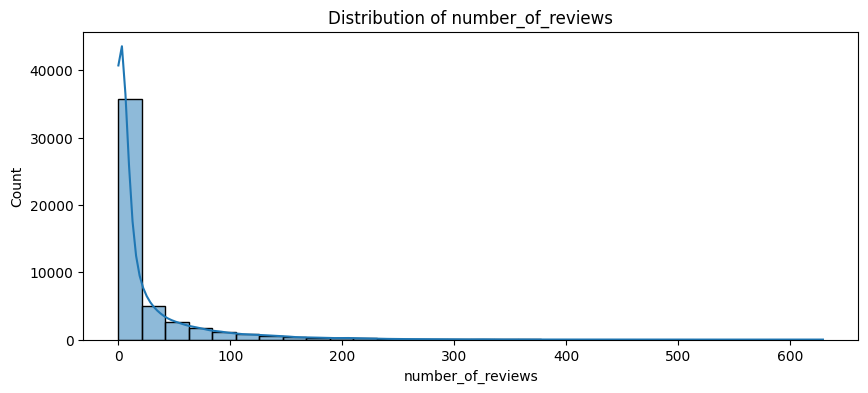

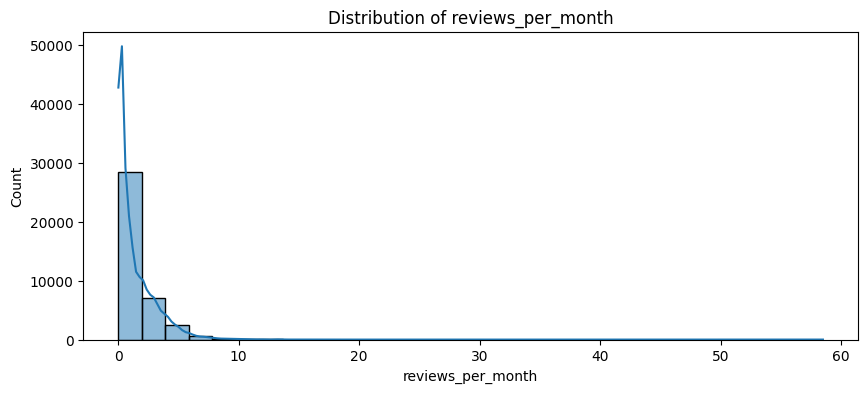

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot distribution for a few key numerical columns
numerical_columns = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']
for col in numerical_columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()


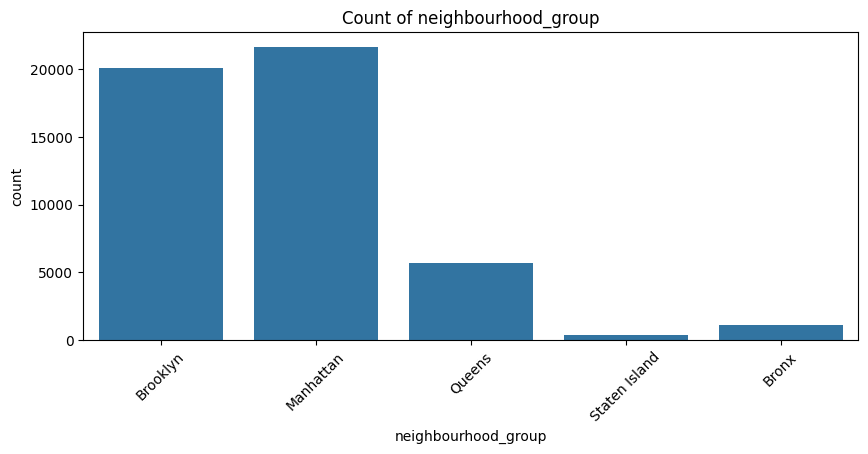

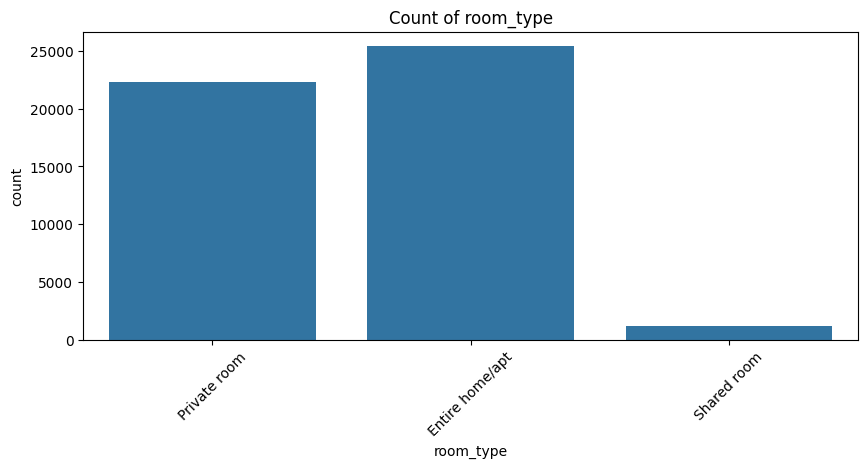

In [9]:
# Count plots for categorical columns
categorical_columns = ['neighbourhood_group', 'room_type']
for col in categorical_columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=col, data=df)
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)
    plt.show()


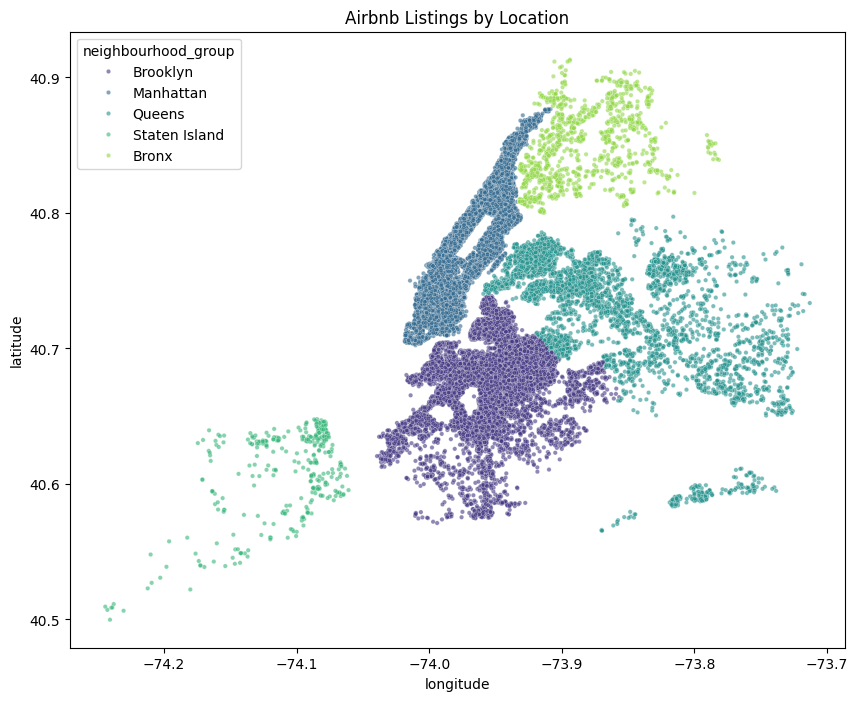

In [10]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='longitude', y='latitude', data=df, hue='neighbourhood_group', palette='viridis', s=10, alpha=0.6)
plt.title('Airbnb Listings by Location')
plt.show()


Auto EDA with Sweetviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 76.0 MB/s eta 0:00:00


                                             |          | [  0%]   00:00 -> (? left)


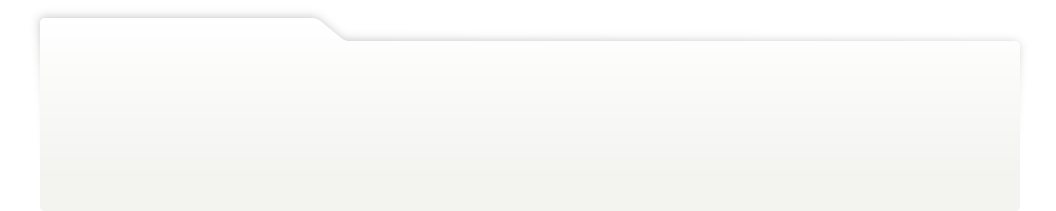
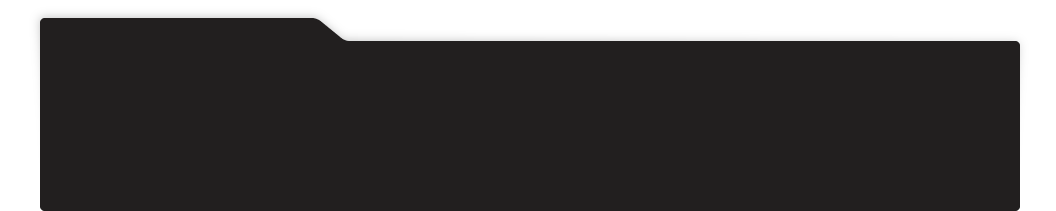
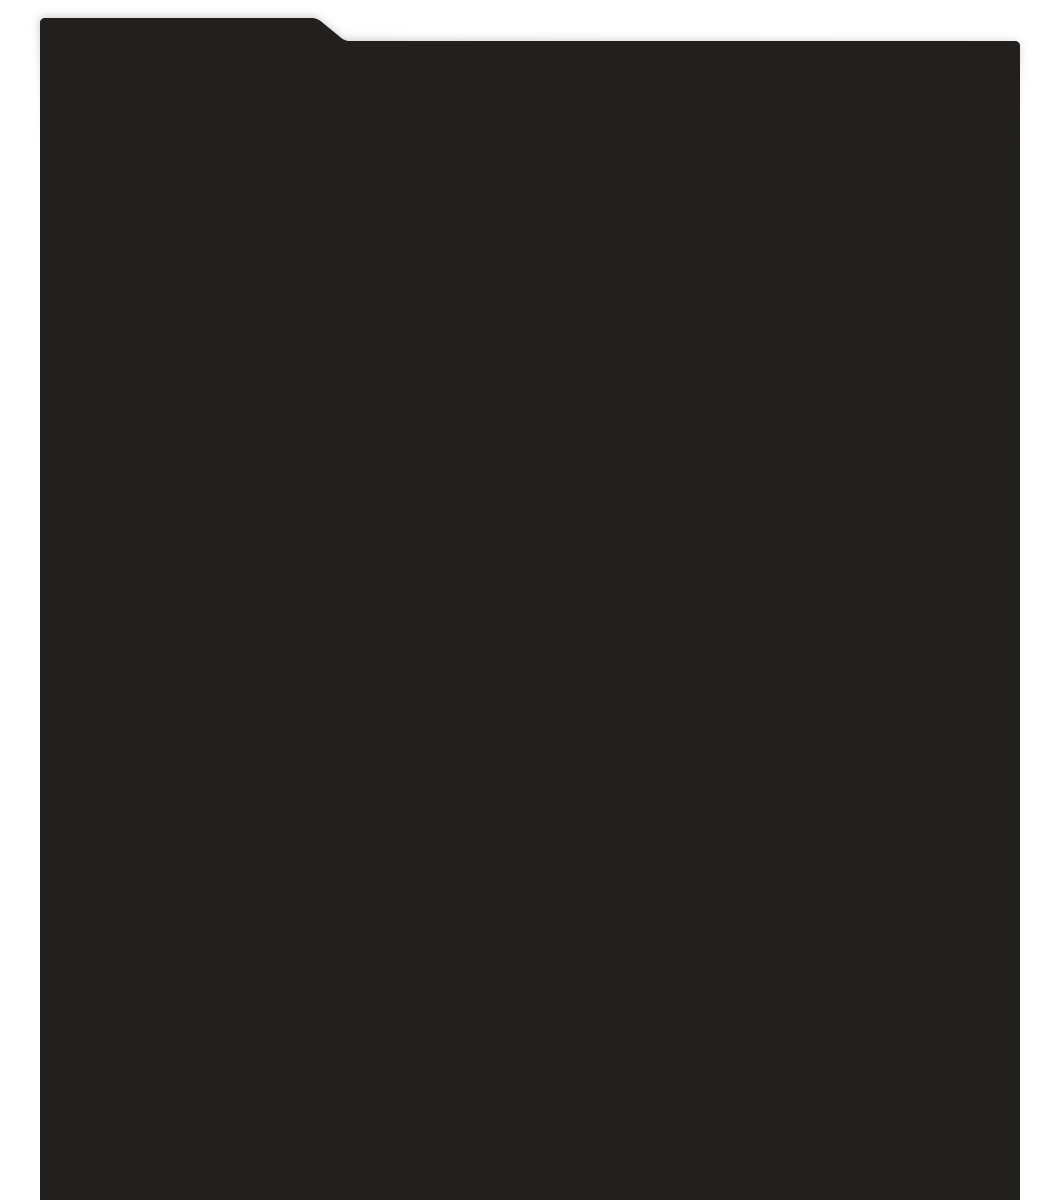
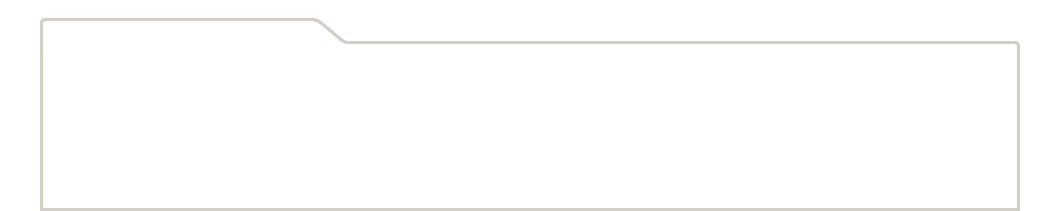
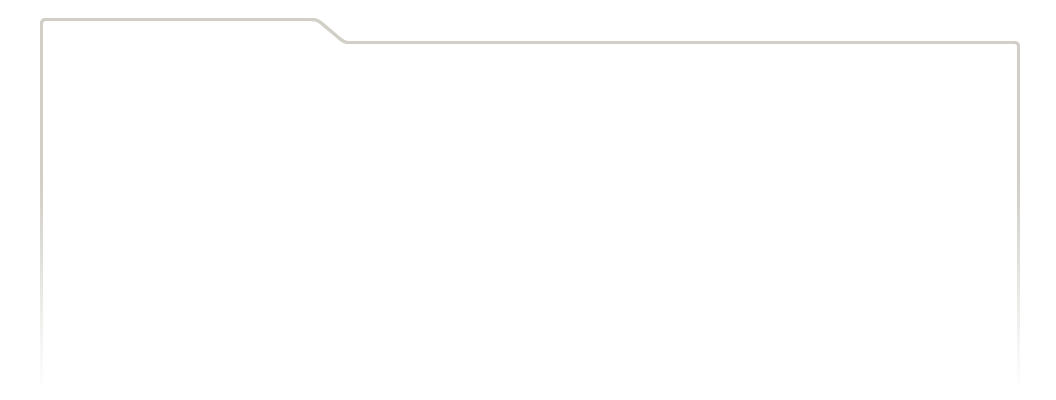
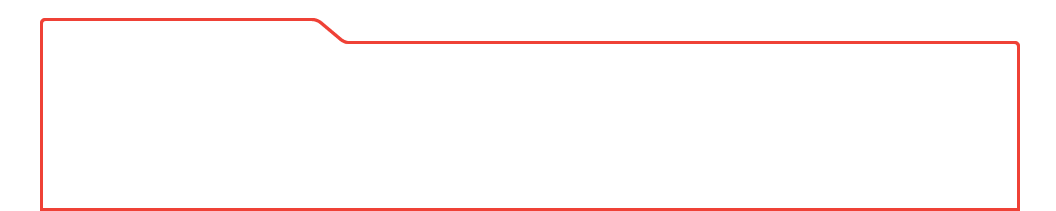
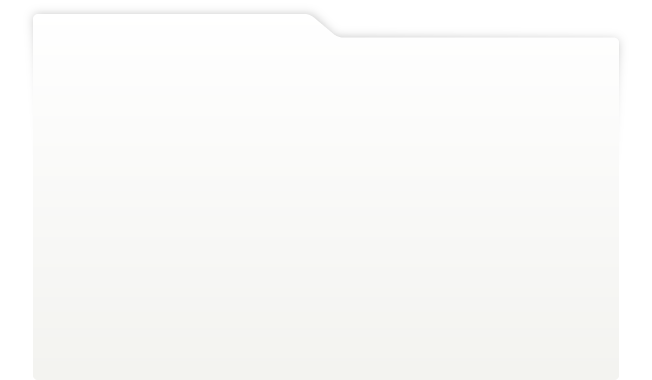
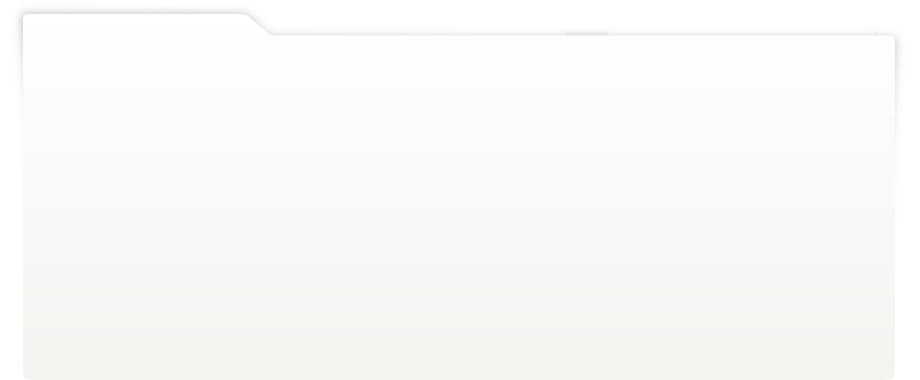
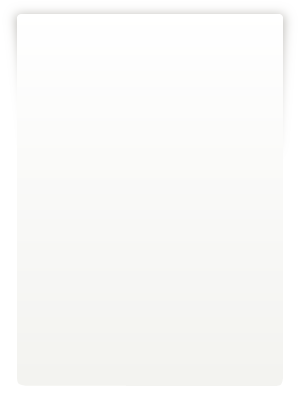
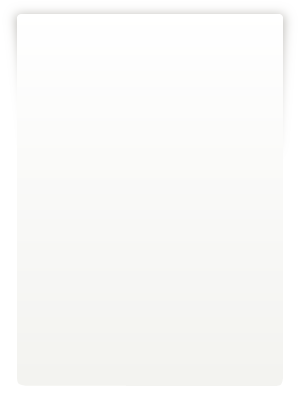
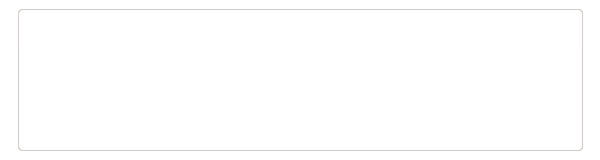
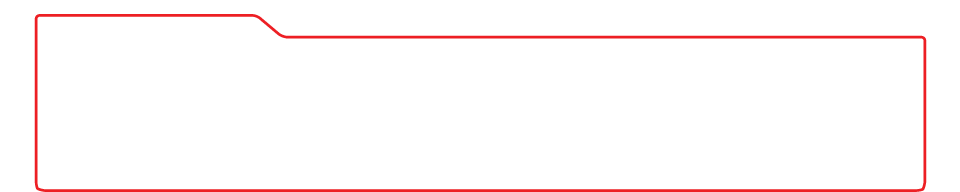
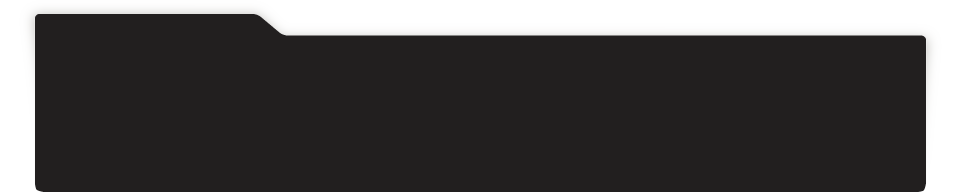
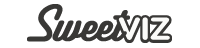
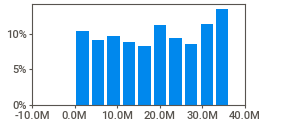
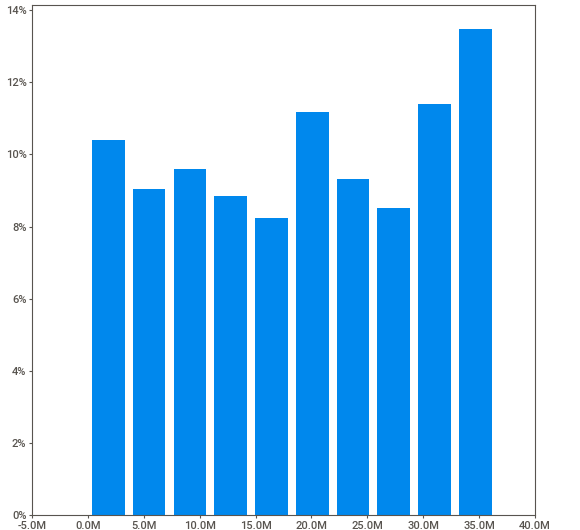
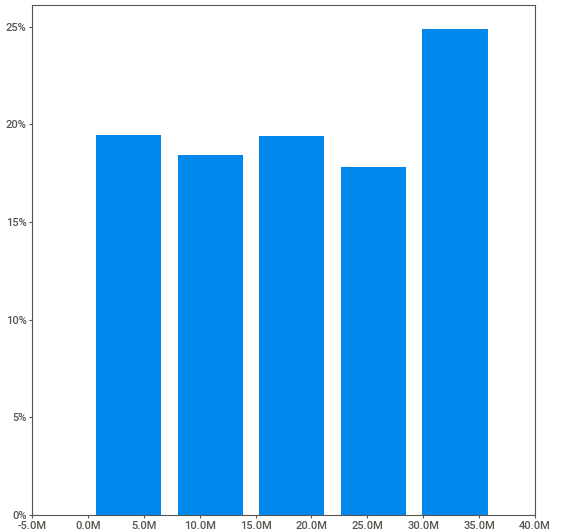
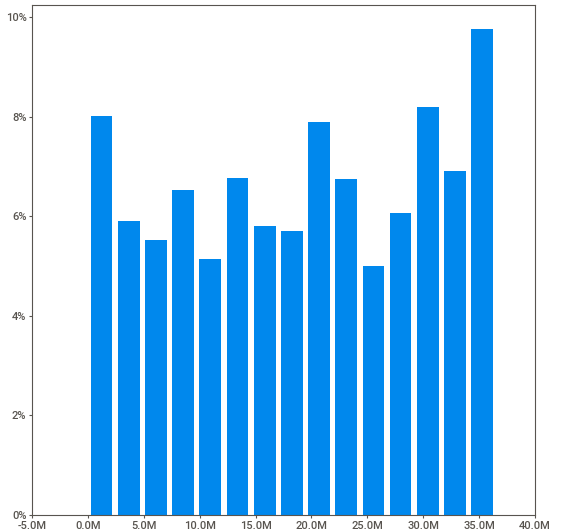
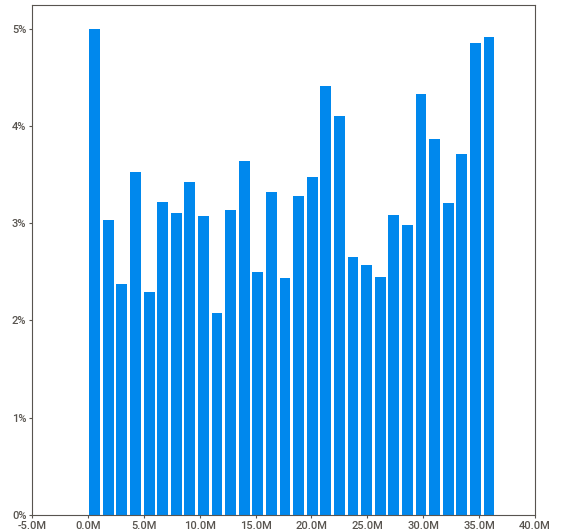
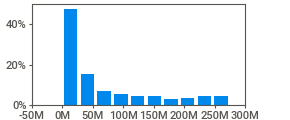
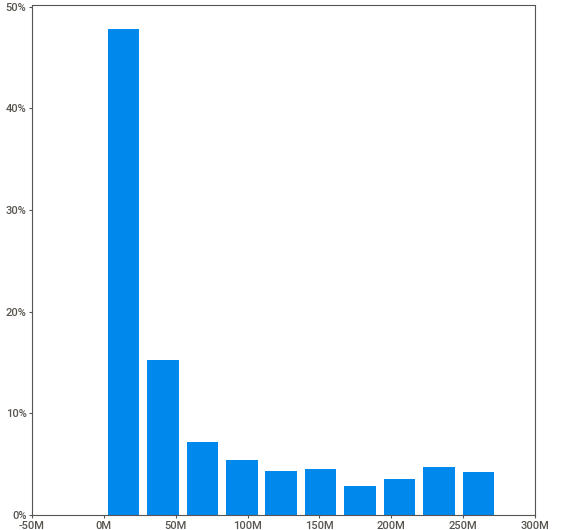
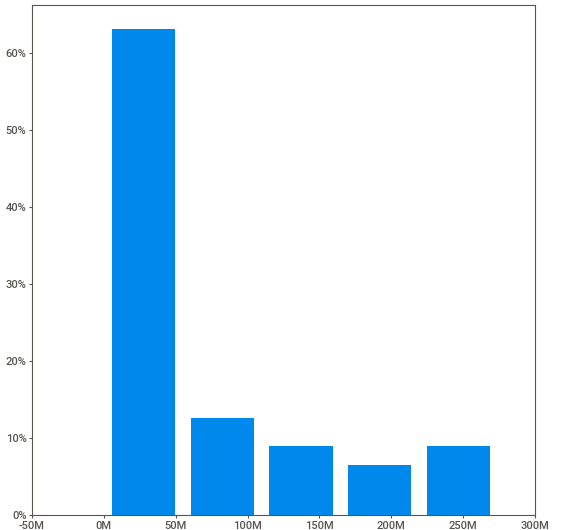
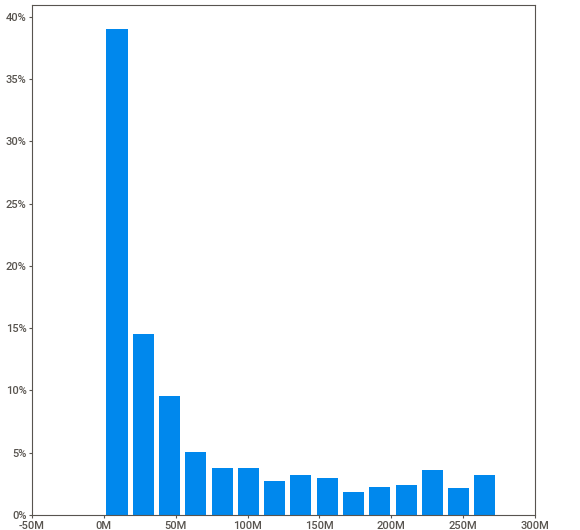
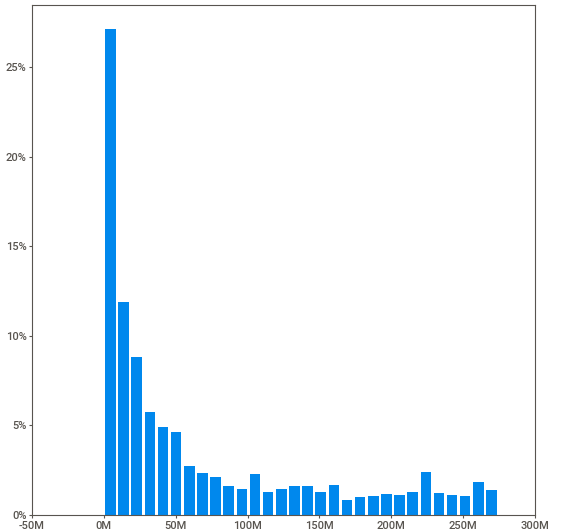
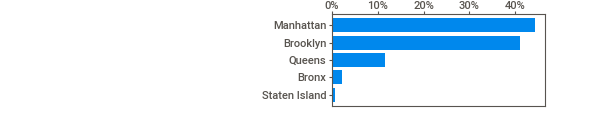
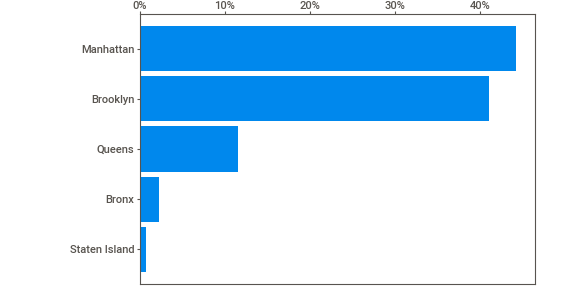
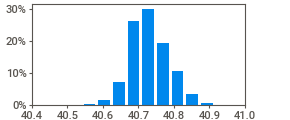
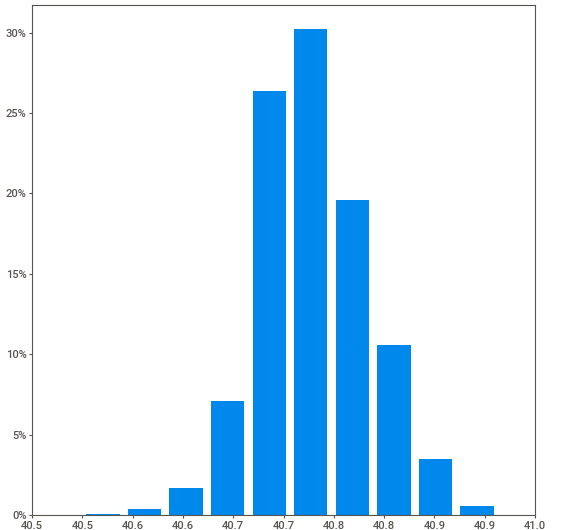
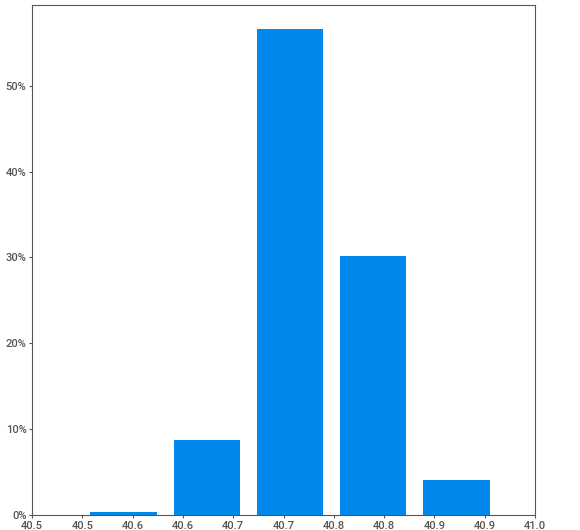
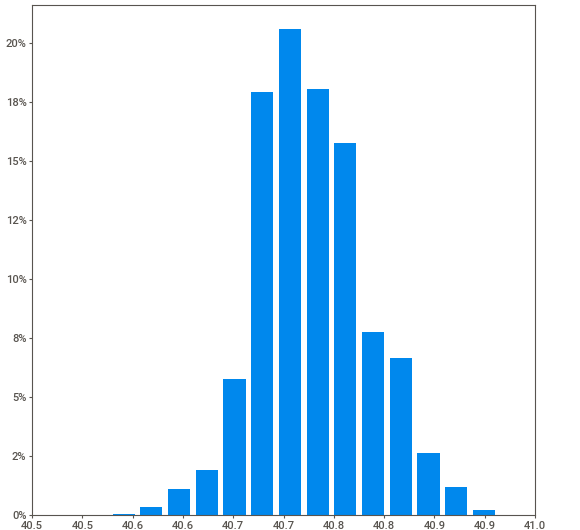
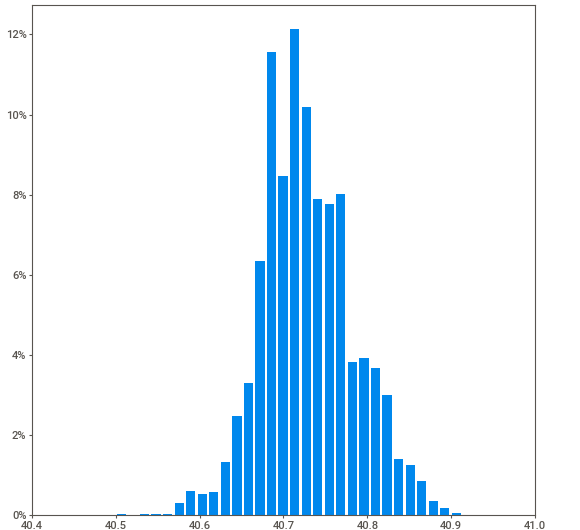
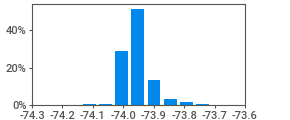
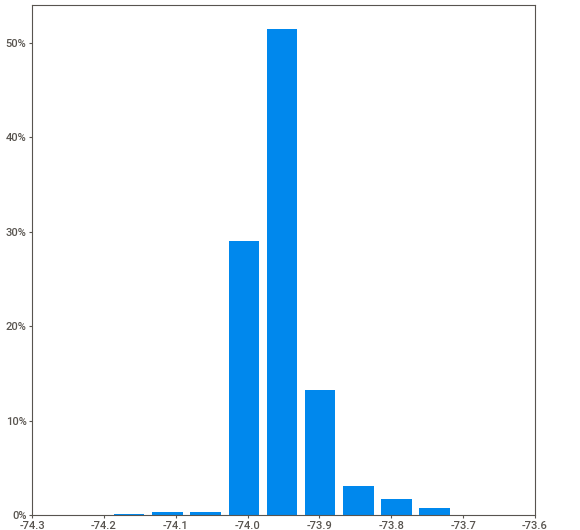
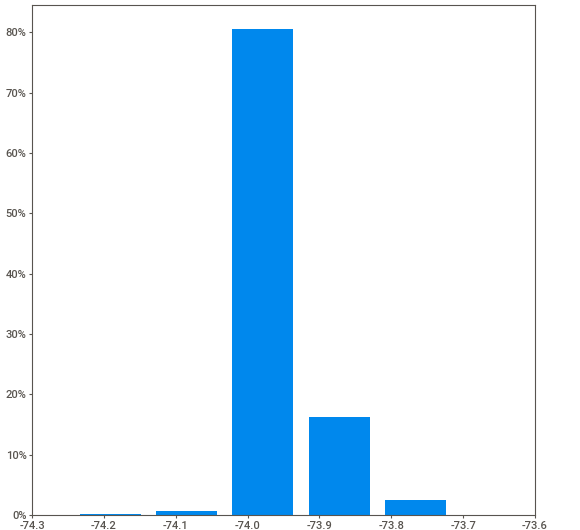
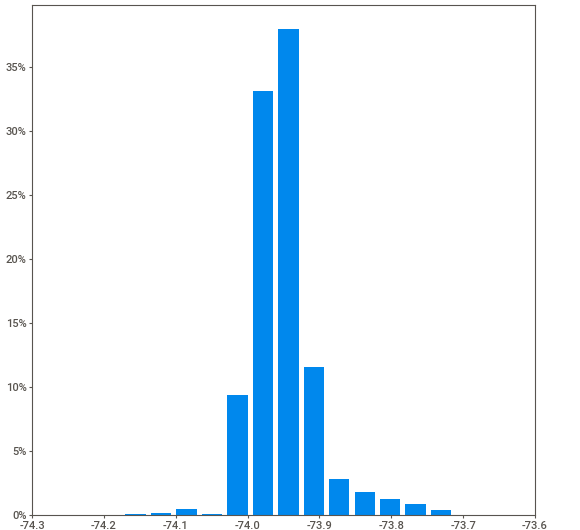
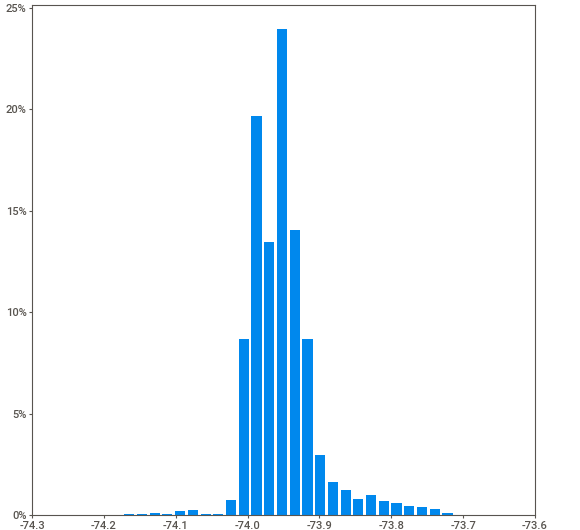
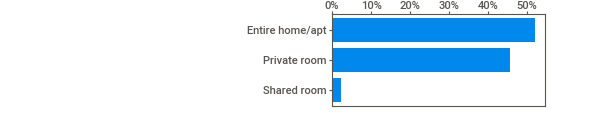
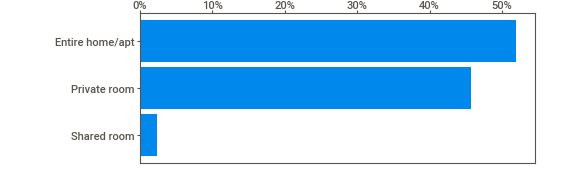
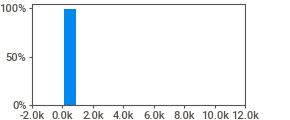
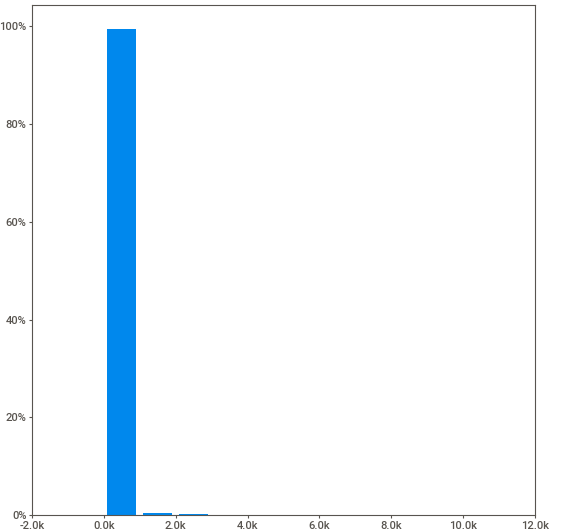
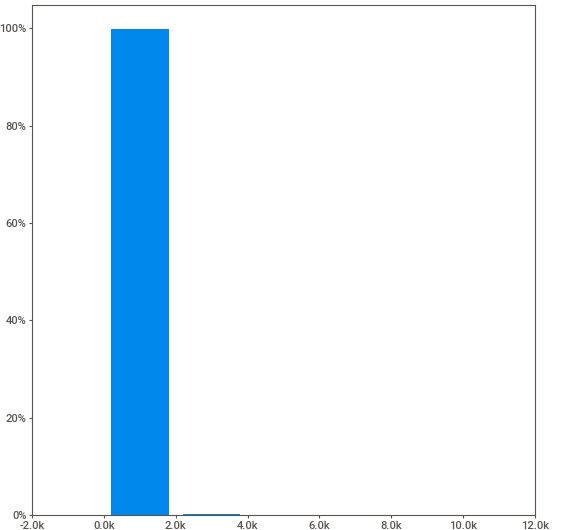
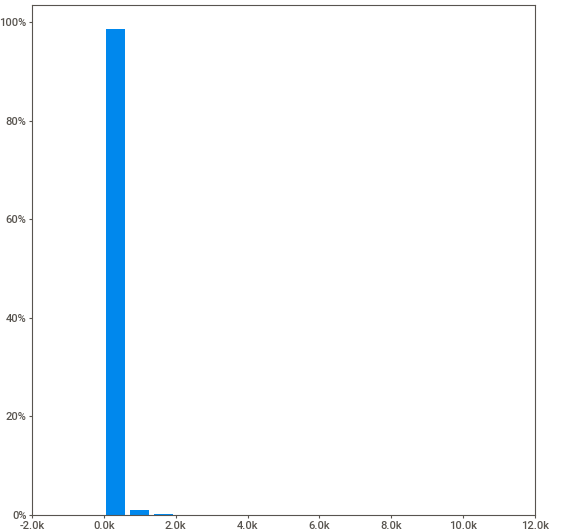
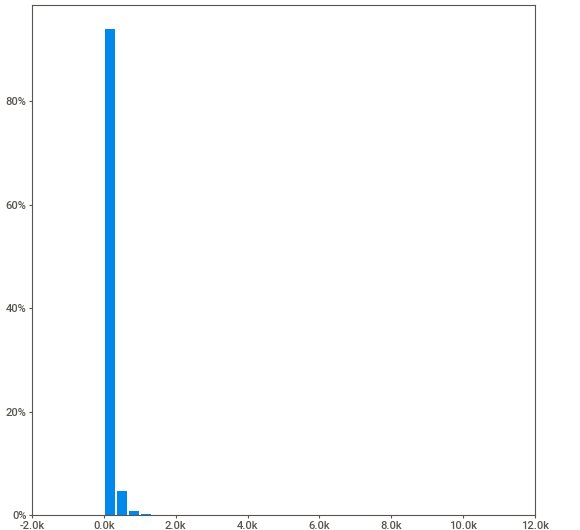
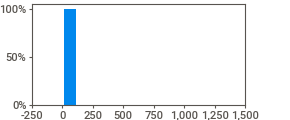
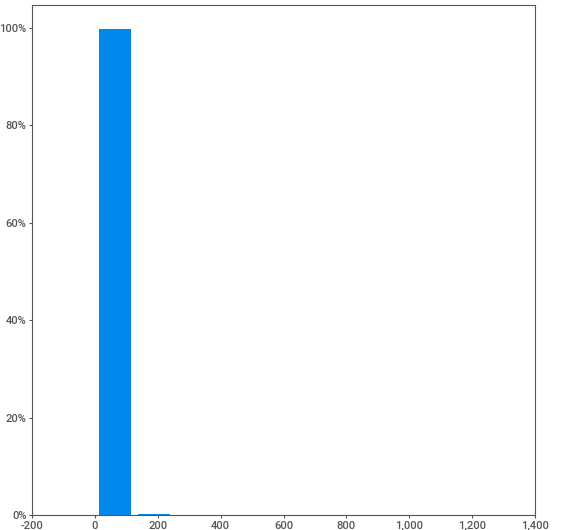
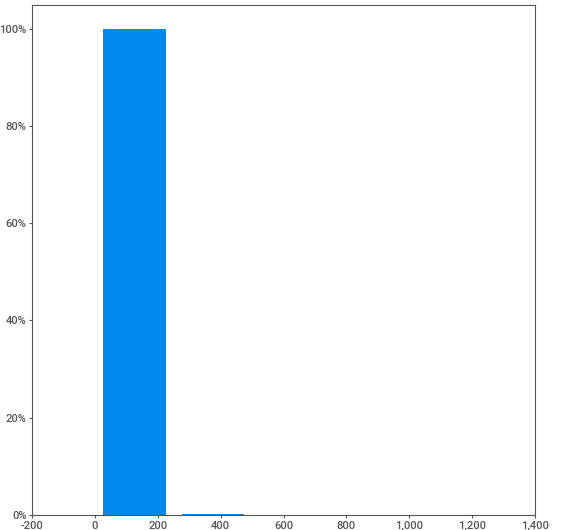
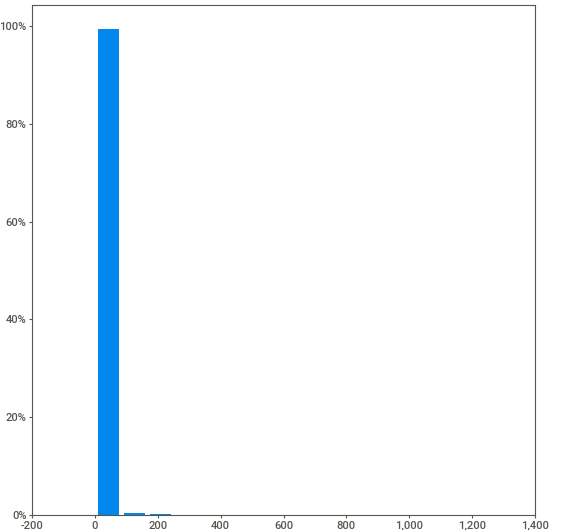
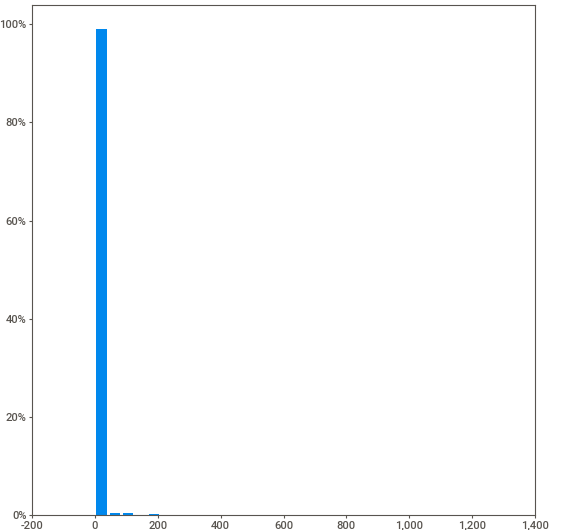
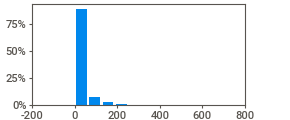
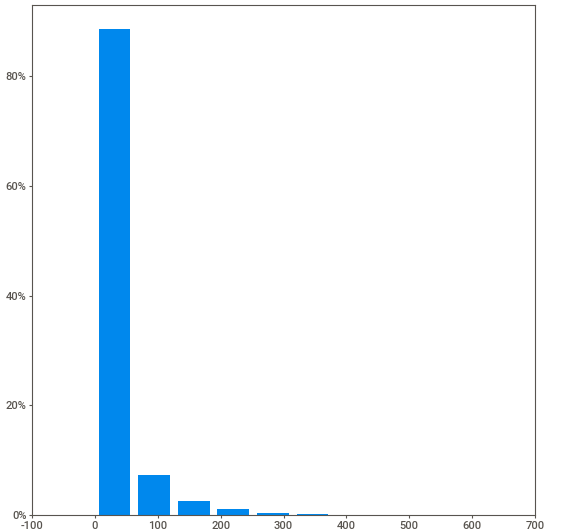
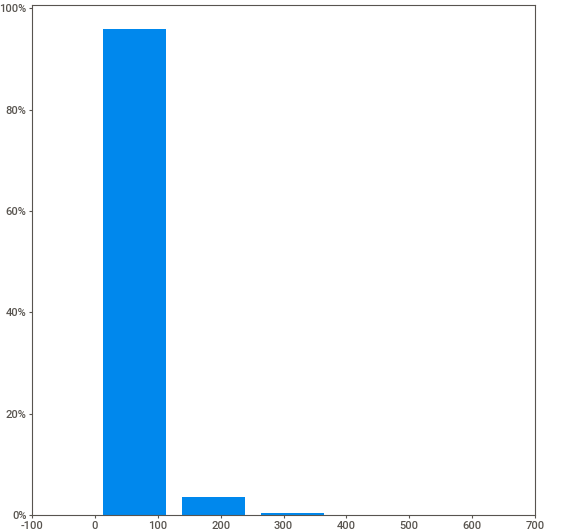
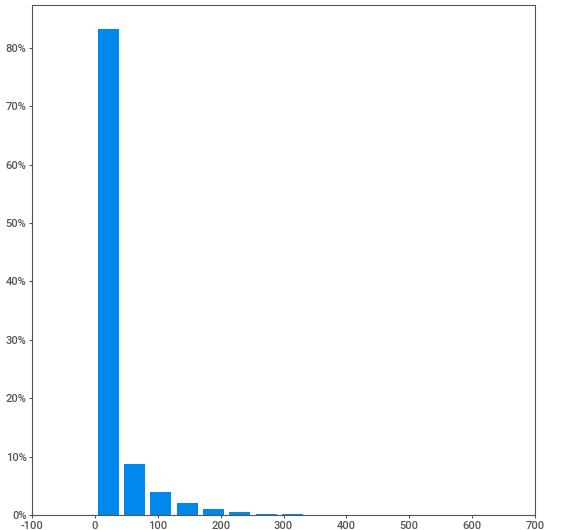
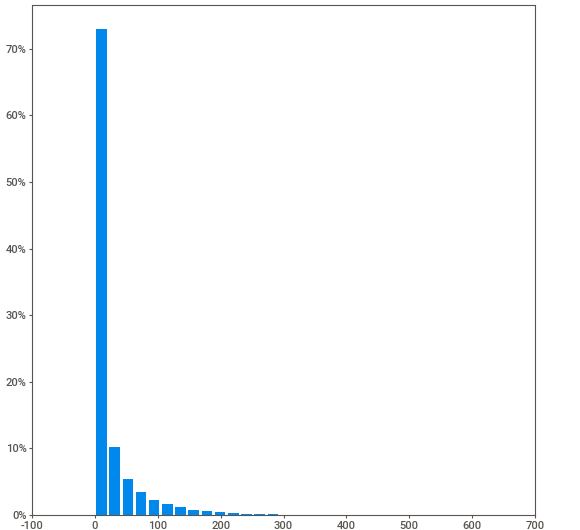
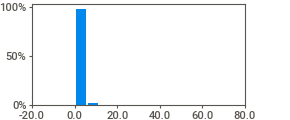
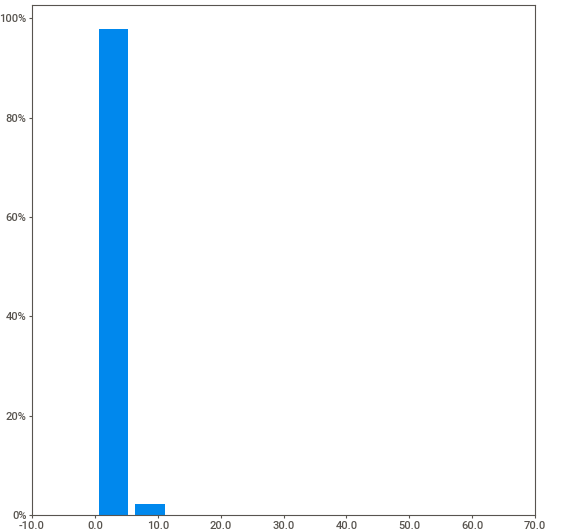
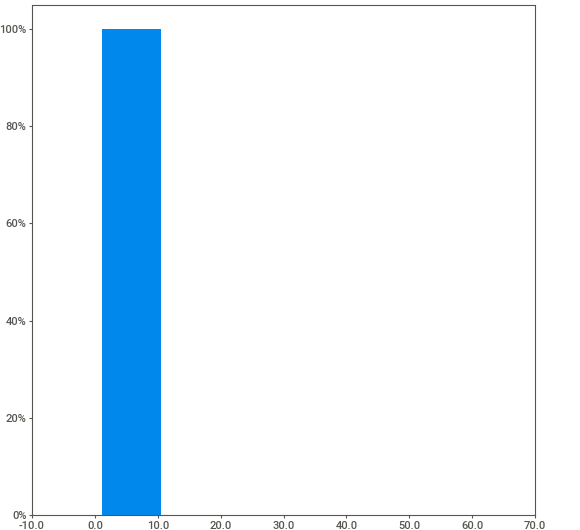
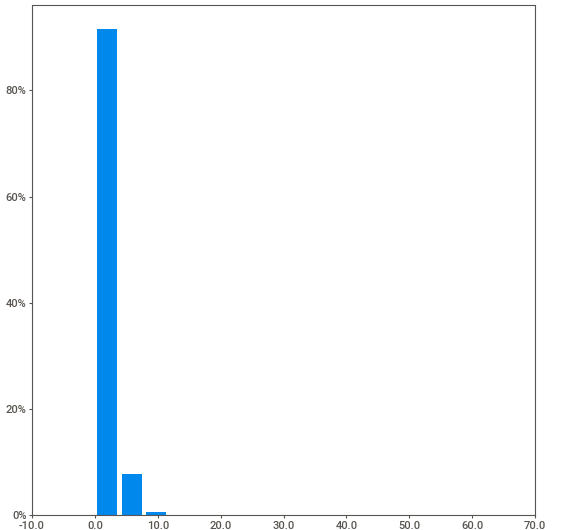
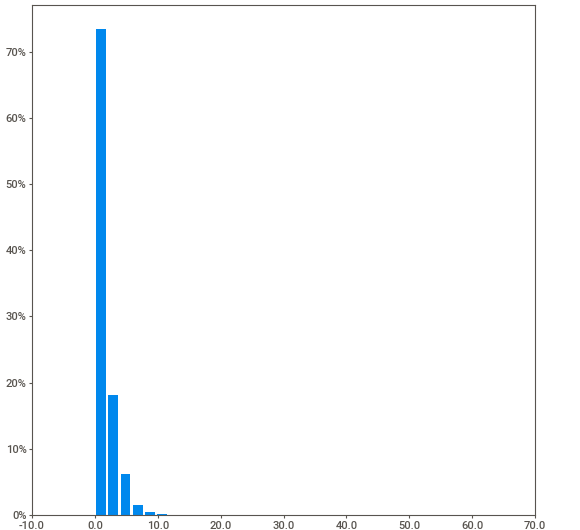
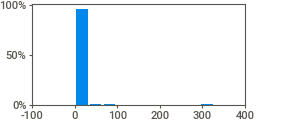
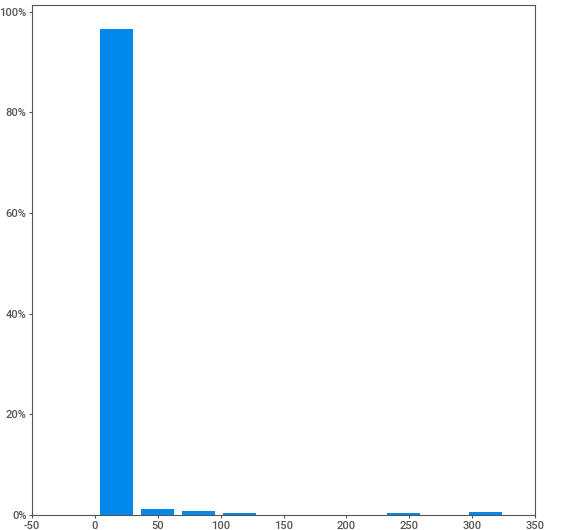
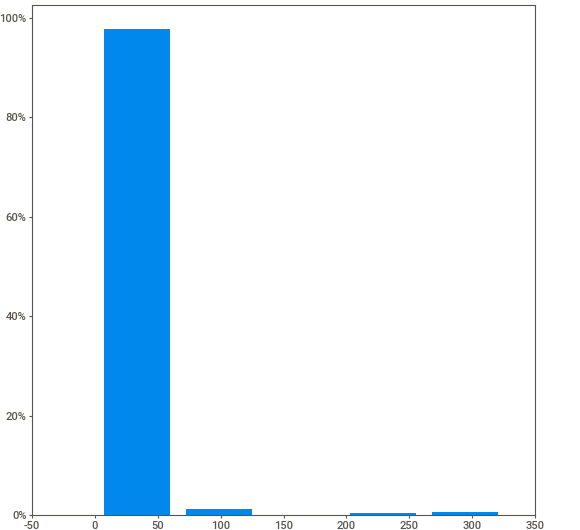
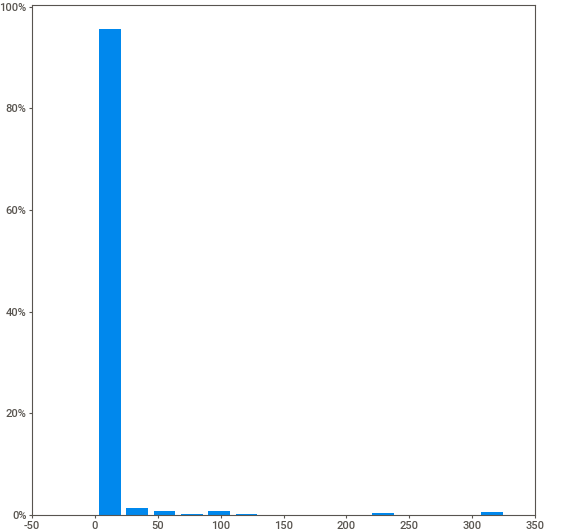
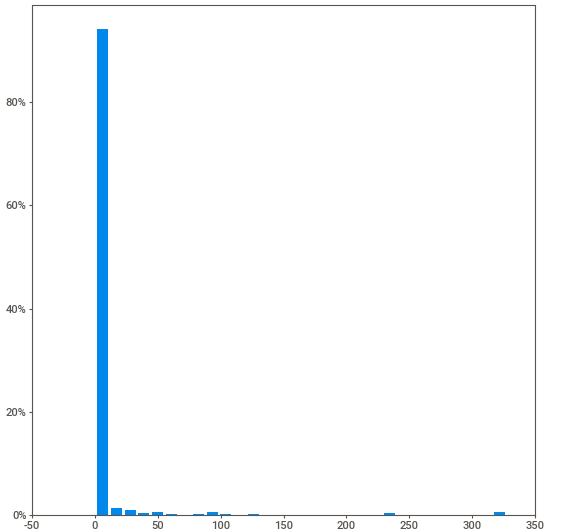
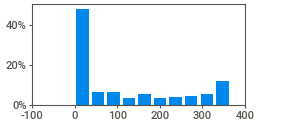
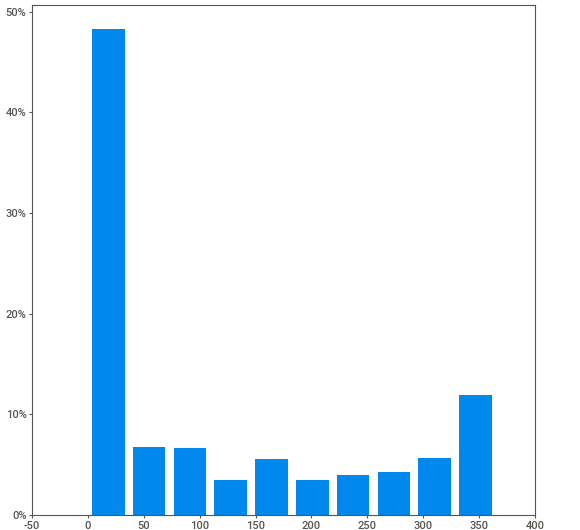
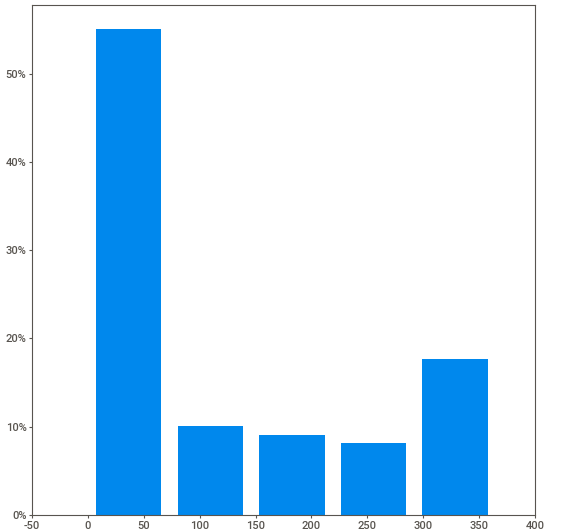
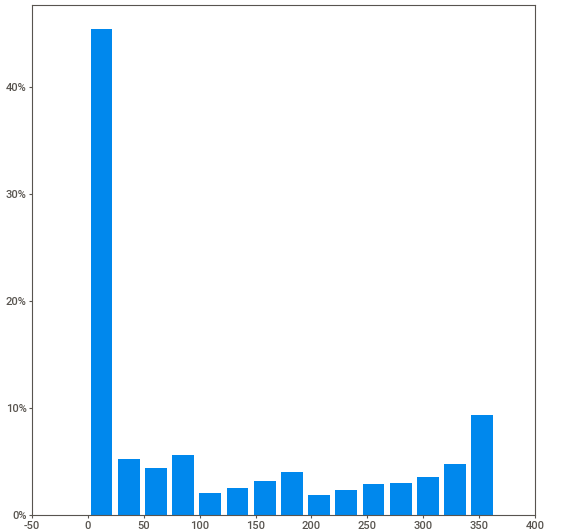
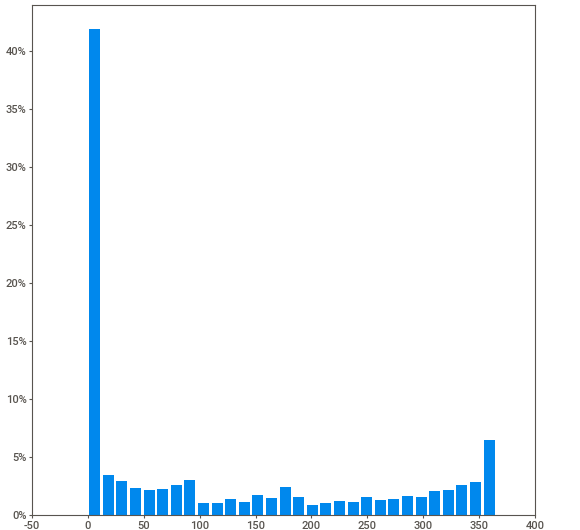
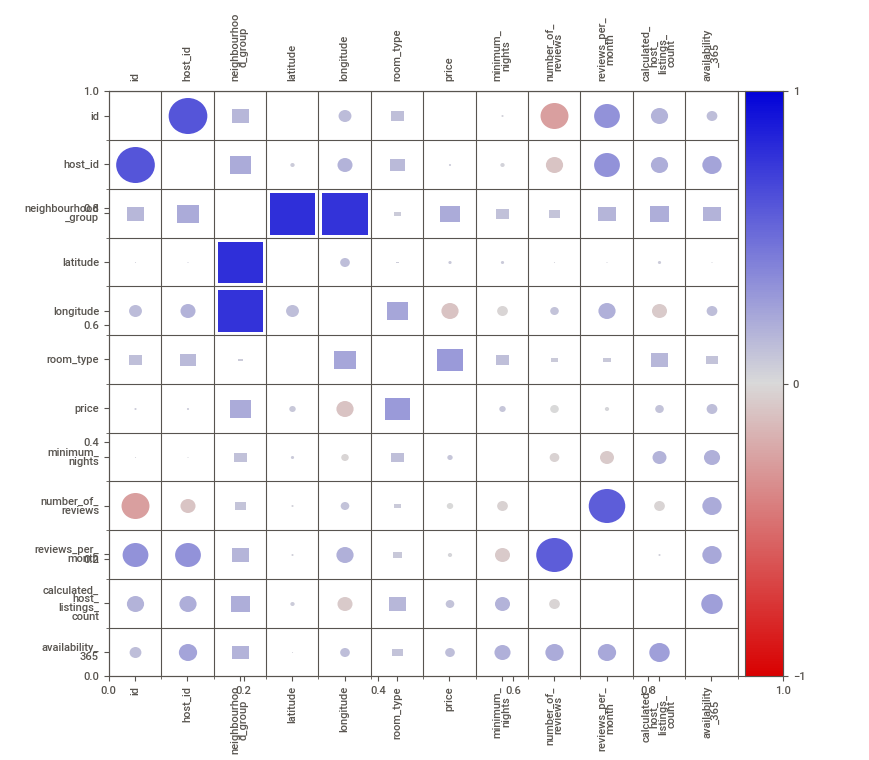
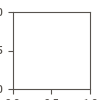

In [11]:
!pip install sweetviz
import sweetviz as sv

report = sv.analyze(df)
report.show_notebook()


Data Preprocessing and Cleaning

1. Handling Missing Values

In [12]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])


Missing Values:
 name                    16
host_name               21
last_review          10052
reviews_per_month    10052
dtype: int64


In [13]:
# Impute missing values in reviews_per_month with the median
df['reviews_per_month'] = df['reviews_per_month'].fillna(df['reviews_per_month'].median())

# Fill missing values in host_name with a placeholder
df['host_name'] = df['host_name'].fillna("Unknown")


2. Remove or Transform Outliers

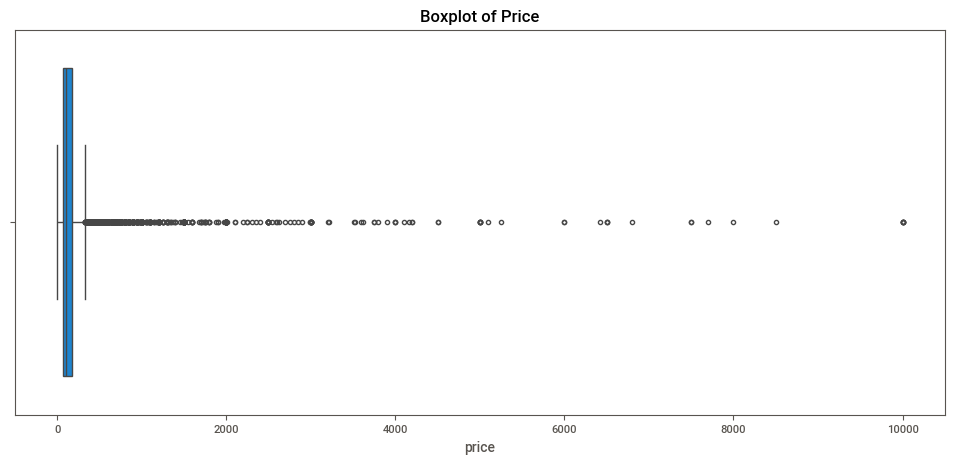

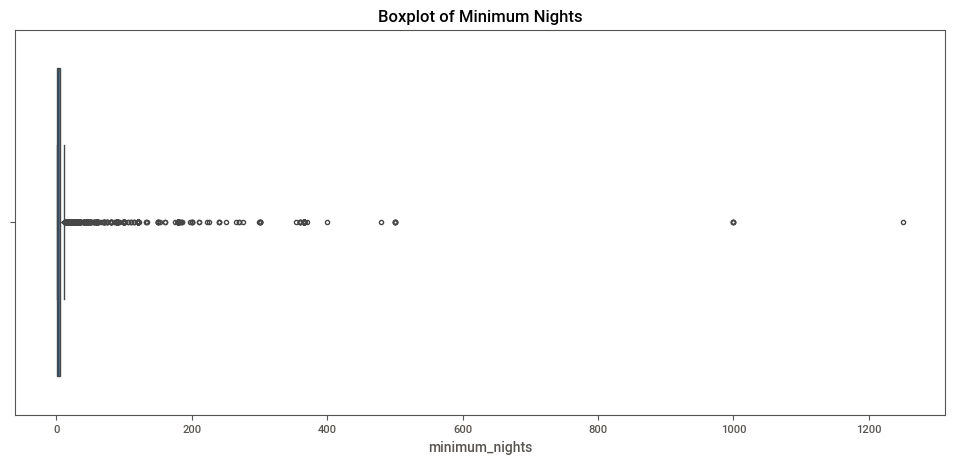

In [14]:
# Plot boxplots to detect outliers in `price` and `minimum_nights`
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.boxplot(x=df['price'])
plt.title('Boxplot of Price')
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x=df['minimum_nights'])
plt.title('Boxplot of Minimum Nights')
plt.show()


In [15]:
# Cap `price` at 99th percentile to handle extreme outliers
price_cap = df['price'].quantile(0.99)
df['price'] = df['price'].apply(lambda x: price_cap if x > price_cap else x)


3. Encoding Categorical Variables

In [16]:
# Perform one-hot encoding
df = pd.get_dummies(df, columns=['neighbourhood_group', 'room_type'], drop_first=True)


4. Scaling Numerical Features

In [17]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# List of numerical columns to scale
num_cols = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'latitude', 'longitude']

# Apply scaling
df[num_cols] = scaler.fit_transform(df[num_cols])


5. Feature Selection

1. Correlation-Based Feature Selection - For numerical features, a correlation matrix can help us identify features that have a strong correlation with each other or the target variable (for example, price). High correlation between features (multicollinearity) can indicate redundancy, which we may want to address by removing one of the highly correlated features.

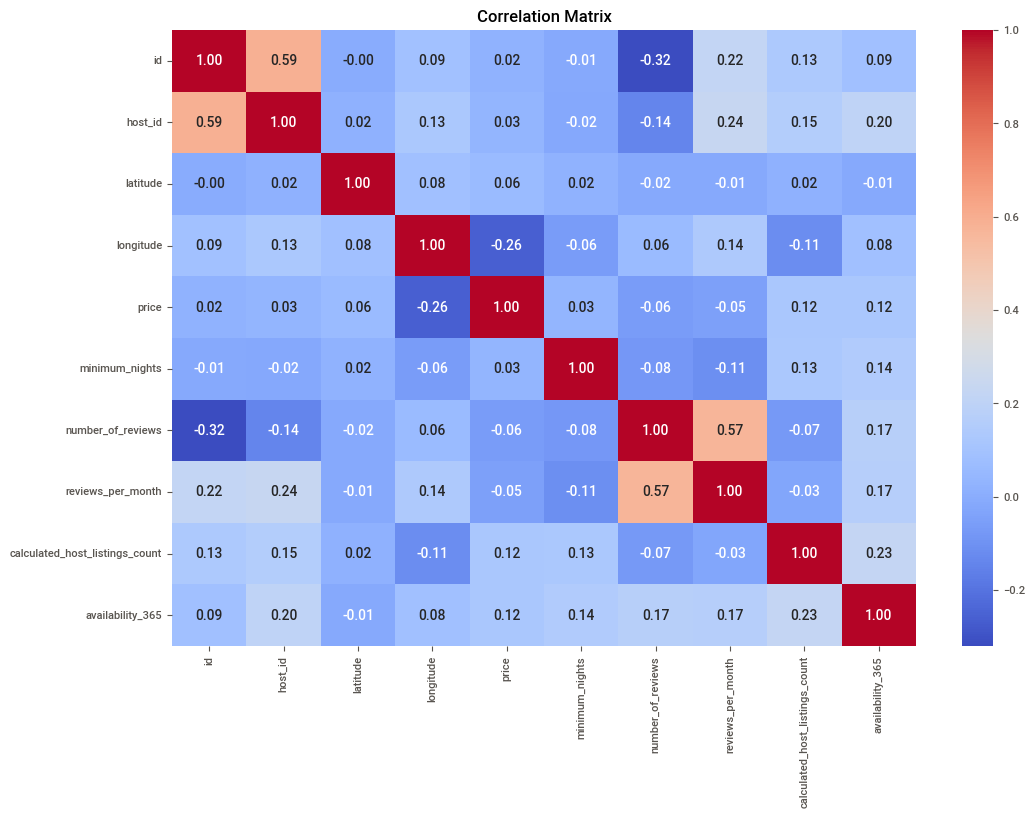

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
# Excluding non-numeric columns from the correlation calculation
numeric_df = df.select_dtypes(include=['number'])  # Select only numeric columns
corr_matrix = numeric_df.corr()

# Plot the correlation matrix for visualization
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


Interpretation from above heatmap:

Look for pairs of features with high correlation values (close to +1 or -1).
If two features are highly correlated, consider removing one to reduce redundancy.

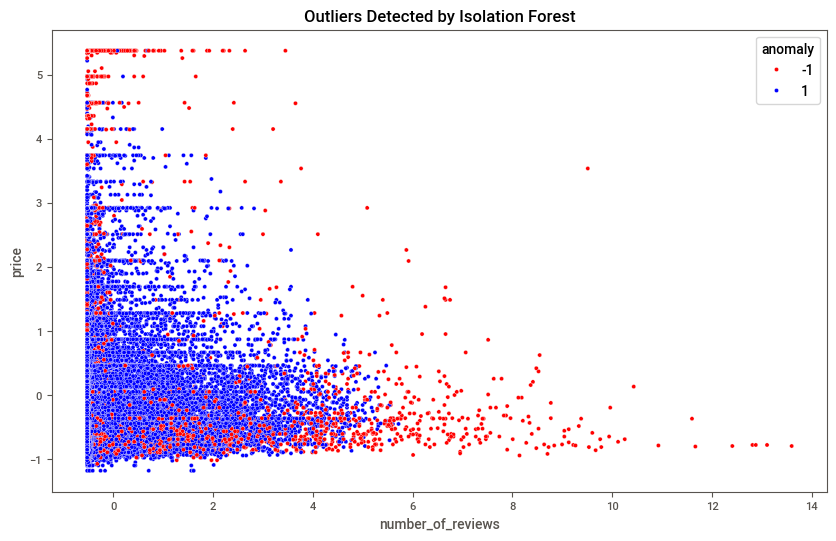

Number of detected outliers: 2445


In [20]:
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer

# Assuming 'df' contains all necessary numerical features for outlier detection
# Assign 'df' to 'X' or copy if necessary
X = df.copy()  # Use copy to avoid modifying the original df

# Select only numerical columns for Isolation Forest
numerical_features = X.select_dtypes(include=['number']).columns
X_numerical = X[numerical_features]

# Impute NaN values with the mean of each column
imputer = SimpleImputer(strategy='mean')  # You can choose other strategies like 'median'
X_numerical_imputed = imputer.fit_transform(X_numerical)

# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # 5% of data as outliers

# Fit the model and predict anomalies using only numerical features
# Use the imputed data for fitting
df['anomaly'] = iso_forest.fit_predict(X_numerical_imputed)

# Extract the outliers
outliers = df[df['anomaly'] == -1]

# Plot outliers for visual inspection (e.g., based on price and number of reviews)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='number_of_reviews', y='price', hue='anomaly', palette={1: 'blue', -1: 'red'})
plt.title('Outliers Detected by Isolation Forest')
plt.show()

print(f"Number of detected outliers: {len(outliers)}")

In [21]:
# Select relevant features for clustering
features_for_clustering = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']  # Adjust as necessary
X_cluster = df[features_for_clustering]


In [22]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)


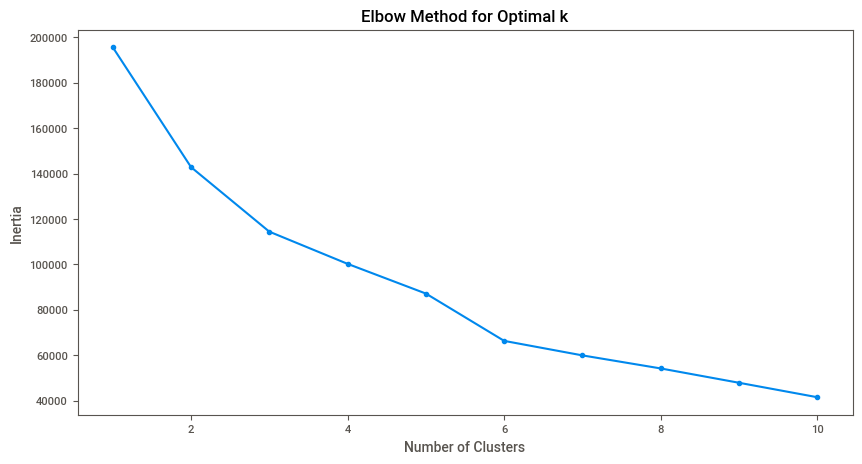

In [23]:
from sklearn.cluster import KMeans

# Elbow method to find the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


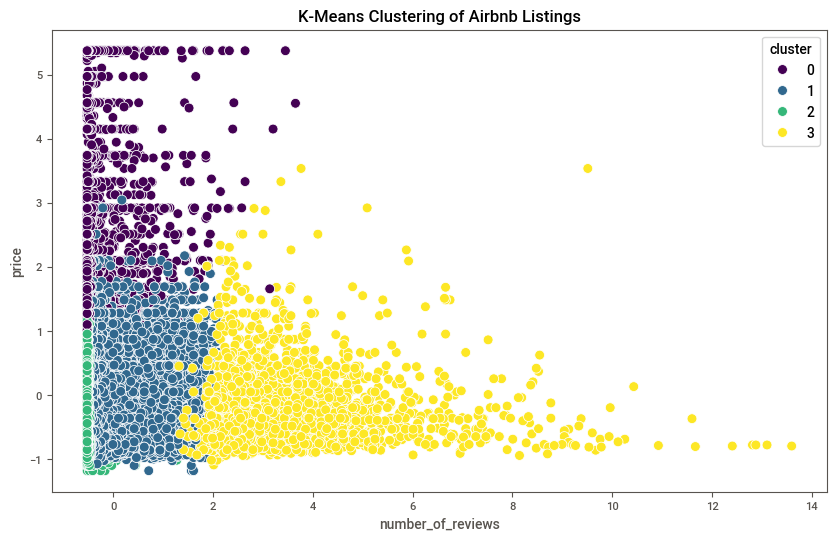

In [24]:
# Fit K-Means with the selected number of clusters
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Visualize the clusters based on two features (e.g., price and number of reviews)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='number_of_reviews', y='price', hue='cluster', palette='viridis', s=50)
plt.title('K-Means Clustering of Airbnb Listings')
plt.show()


AutoML using VIML

In [29]:
!pip install autoviml


  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipykernel 6.29.5 which is inc

In [1]:
import numpy as np

# Custom function to replace scipy's deprecated interp
def interp(x, xp, fp):
    return np.interp(x, xp, fp)


In [2]:
!sed -i 's/from scipy import interp/import numpy as np\ninterp = lambda x, xp, fp: np.interp(x, xp, fp)/' /usr/local/lib/python3.10/dist-packages/autoviml/Auto_ViML.py


sed: can't read /usr/local/lib/python3.10/dist-packages/autoviml/Auto_ViML.py: No such file or directory


In [9]:
from autoviml.Auto_ViML import Auto_ViML


# Define the target and feature columns
target = 'price'  # Assuming we're predicting price
X = df.drop(columns=[target])
y = df[target]


In [10]:
from sklearn.model_selection import train_test_split

# Perform the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
X_train[target] = y_train


##############  D A T A   S E T  A N A L Y S I S  #######################
ALERT! Changing hyperparameter search to RS. Otherwise, Random Forests will take too long for 10,000+ rows
Training Set Shape = (39116, 16)
    Training Set Memory Usage = 5.07 MB
Test Set Shape = (9779, 15)
    Test Set Memory Usage = 1.19 MB
Single_Label Target: ['price']

################ Regression VISUALIZATION Started #####################
No shuffling of data set before training...
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  3
    Number of Integer-Categorical Columns =  5
    Number of String-Categorical Columns =  2
    Numbe

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

Auto NLP processing on NLP Column: name
Shape of Train Data: 39116 rows
    Shape of Test Data: 9779 rows
    Added 9 summary columns for counts of words and characters in each row
Cleaning text in Train data for name column
    Faster text processing using clean_text function, since top_num_features is below 300
    Time Taken for Expanding emojis and abbreviations in data = 1 seconds
Auto_NLP error. Continuing without NLP processing


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

Auto NLP processing on NLP Column: host_name
Shape of Train Data: 39116 rows
    Shape of Test Data: 9779 rows
    Added 9 summary columns for counts of words and characters in each row
Cleaning text in Train data for host_name column
    Faster text processing using clean_text function, since top_num_features is below 300
    Time Taken for Expanding emojis and abbreviations in data = 0 seconds
Auto_NLP error. Continuing without NLP processing
Auto NLP processing on NLP Column: last_review
Shape of Train Data: 39116 rows
    Shape of Test Data: 9779 rows


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

    Added 9 summary columns for counts of words and characters in each row
Cleaning text in Train data for last_review column
    Faster text processing using clean_text function, since top_num_features is below 300
    Time Taken for Expanding emojis and abbreviations in data = 0 seconds
Auto_NLP error. Continuing without NLP processing
#######################################################################################
#####  SULOV:  Searching for Uncorrelated List Of Variables in 3 features ############
#######################################################################################
    there are no null values in dataset...


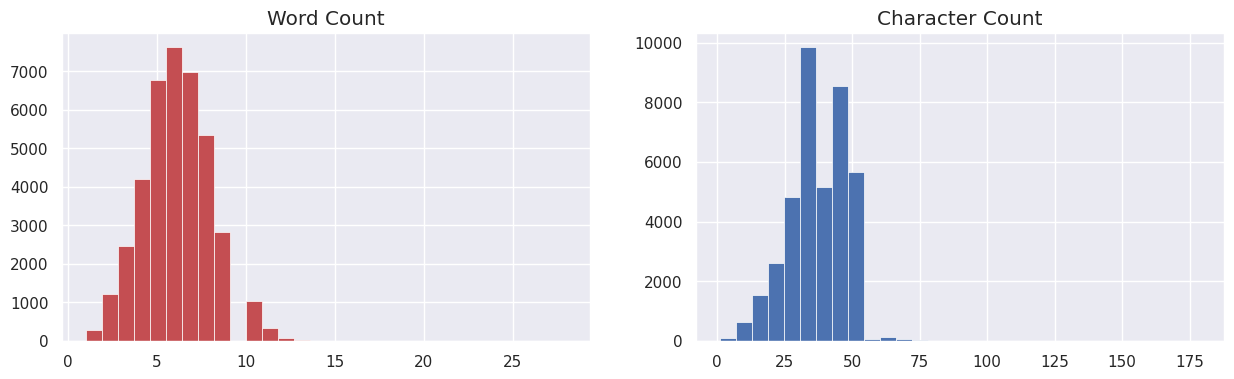

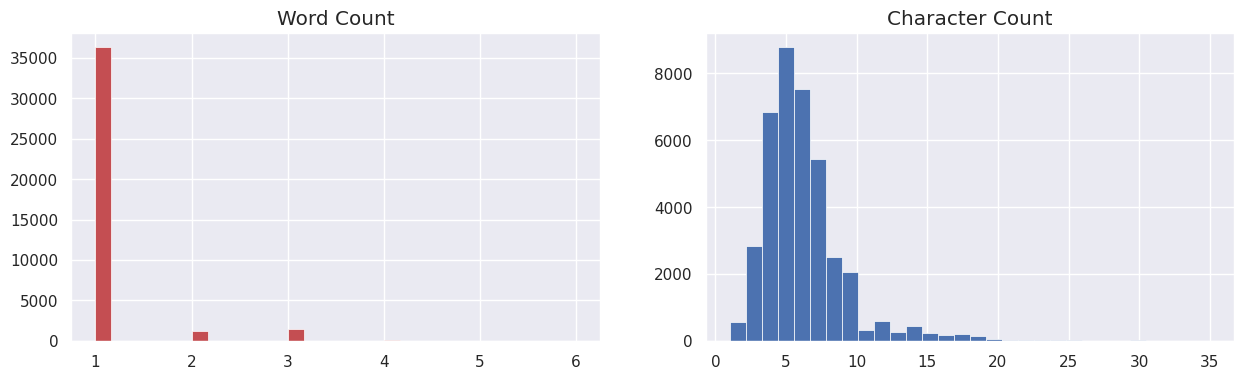

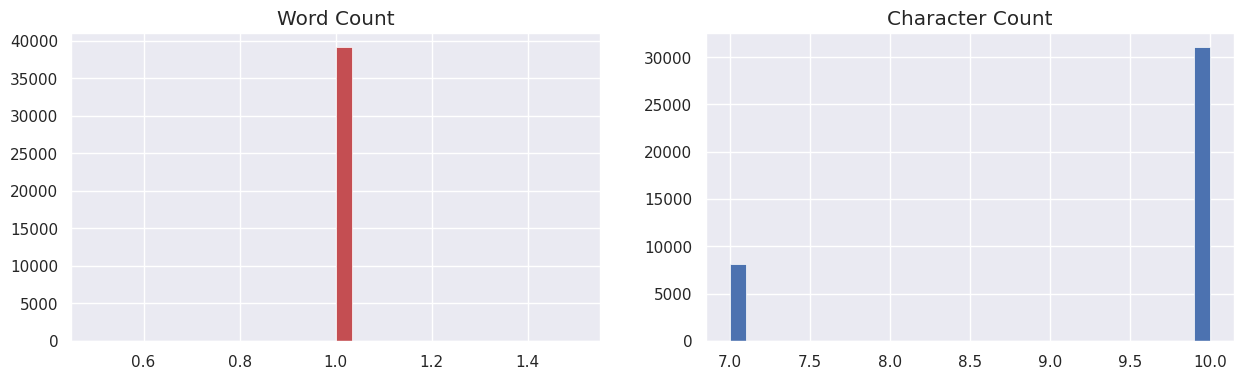

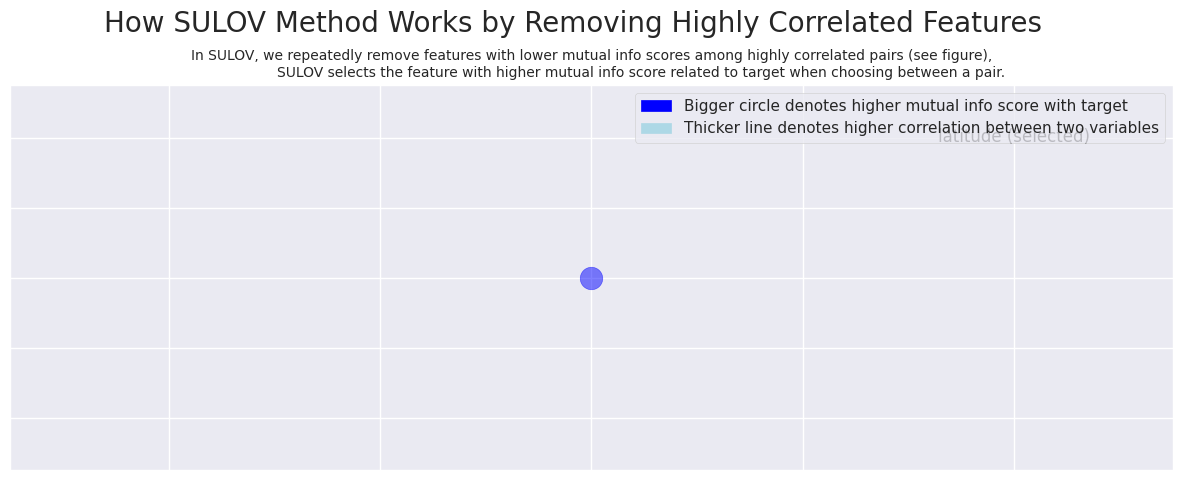

Splitting selected features into float and categorical (integer) variables:
    (3) float variables ...
    (12) categorical vars...
###############################################################################
#######     F E A T U R E   S E L E C T I O N    BY   X G B O O S T    ########
###############################################################################
Current number of predictors = 15 
    Finding Important Features using Boosted Trees algorithm...
        using 15 variables...
        using 12 variables...
        using 9 variables...
        using 6 variables...
        using 3 variables...
Found 15 important features
    Performing limited feature engineering for binning, add_poly and KMeans_Featurizer flags  ...
    Train CV Split completed with TRAIN rows =  31292 , CV rows =  7824
    Binning_Flag set to False or there are no float vars in data set to be binned
    KMeans_Featurizer set to False or there are no float variables in data
Performing MinMax scaling 

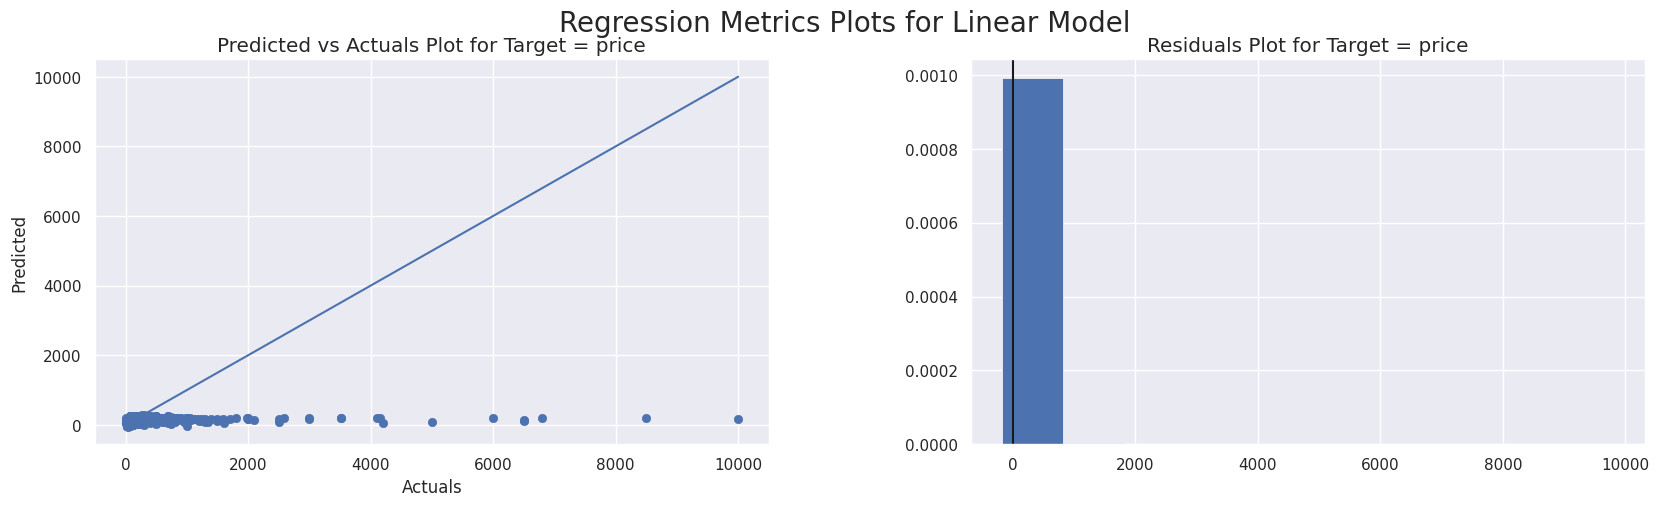

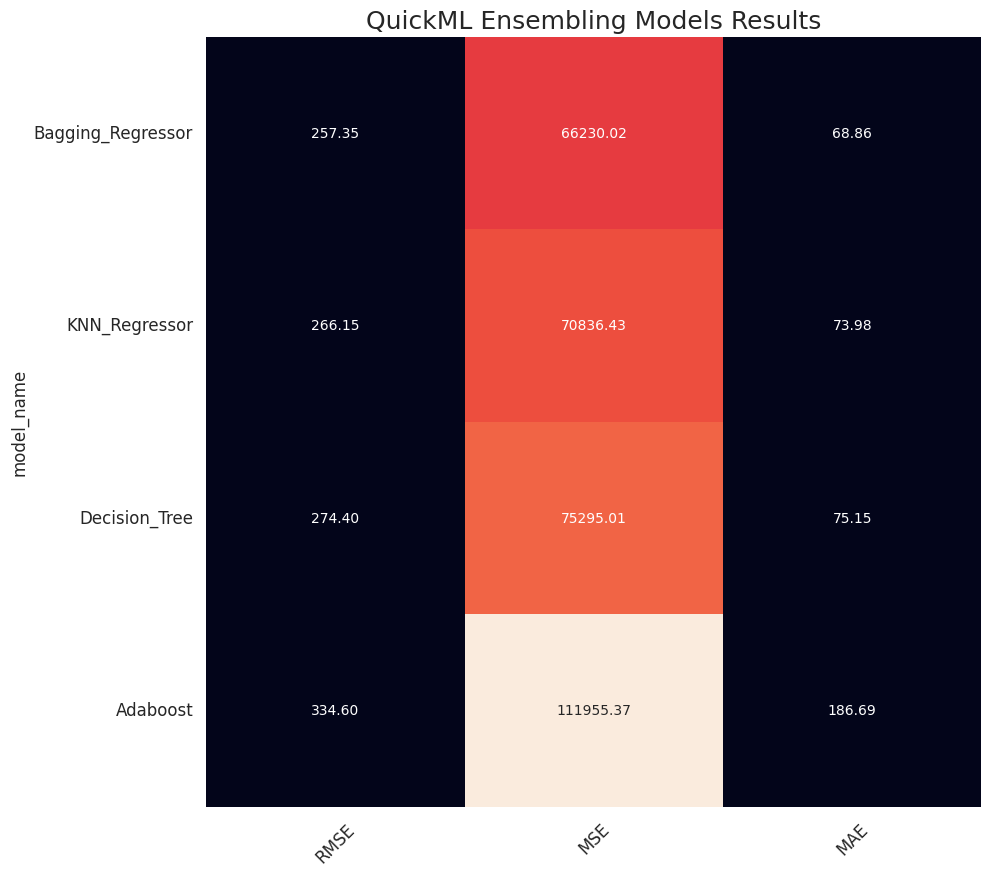

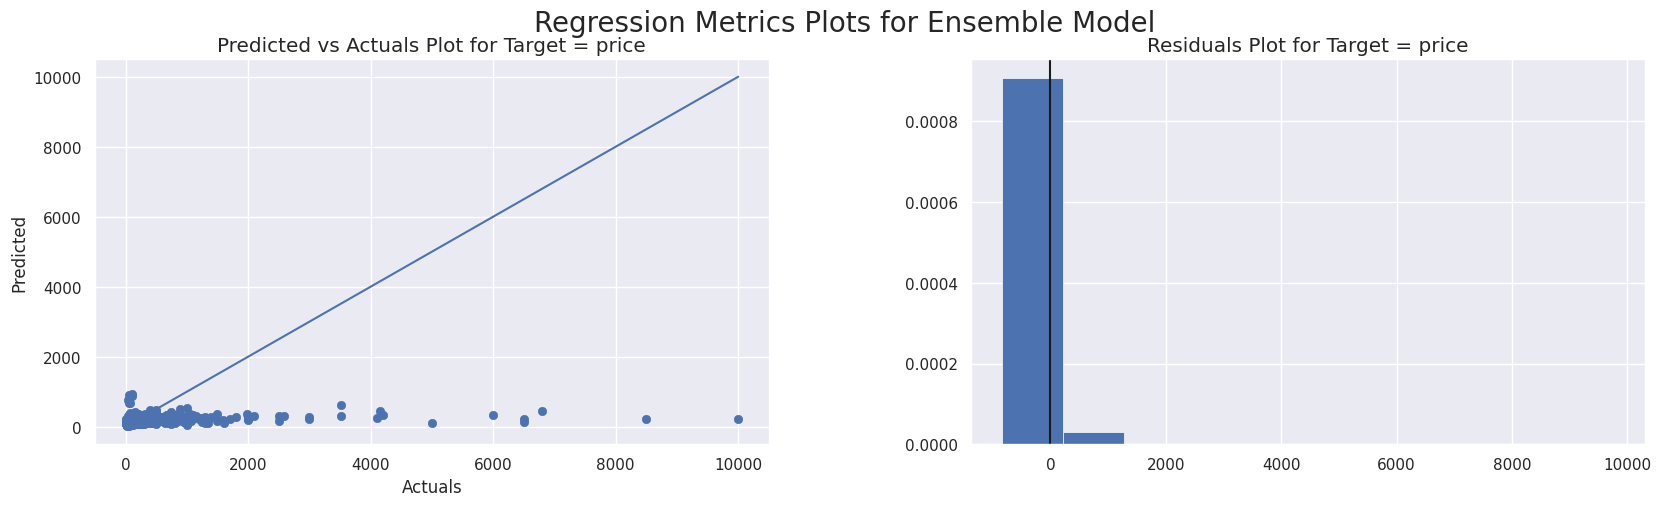

<Figure size 1500x500 with 0 Axes>

In [16]:
result = Auto_ViML(
    train=X_train, target=target, test=X_test, scoring_parameter='r2',
    hyper_param='RS', feature_reduction=True, verbose=1
)


In [17]:
print(result)

(LinearSVR(C=80.80499633648476, epsilon=0.5656174196105306, max_iter=4000,
          random_state=99, tol=0.001), ['room_type', 'neighbourhood', 'neighbourhood_group', 'longitude', 'availability_365', 'latitude', 'calculated_host_listings_count', 'minimum_nights', 'reviews_per_month_Missing_Flag', 'reviews_per_month', 'name_Missing_Flag', 'host_id', 'last_review_Missing_Flag', 'number_of_reviews', 'host_name_Missing_Flag'],        room_type  neighbourhood  neighbourhood_group  longitude  \
32645          0            214                    1     -73.96   
23615          1            206                    2     -73.94   
31183          1             13                    1     -73.96   
29260          0             13                    1     -73.93   
7275           1            219                    3     -73.90   
...          ...            ...                  ...        ...   
11284          2            206                    2     -73.94   
44732          1             34     

In [18]:
model = result[0]  # The main trained model
selected_features = result[1]  # List of selected features


In [19]:
train_predictions = result[2]  # Contains original training data with added prediction columns
print(train_predictions.head())


       room_type  neighbourhood  neighbourhood_group  longitude  \
32645          0            214                    1     -73.96   
23615          1            206                    2     -73.94   
31183          1             13                    1     -73.96   
29260          0             13                    1     -73.93   
7275           1            219                    3     -73.90   

       availability_365  latitude  calculated_host_listings_count  \
32645                 1     40.72                               1   
23615                 0     40.85                               1   
31183                 0     40.69                               2   
29260               267     40.68                               1   
7275                  0     40.75                               1   

       minimum_nights  reviews_per_month_Missing_Flag  reviews_per_month  \
32645               3                               0               0.87   
23615               2         

In [20]:
stest_predictions = result[3]  # Contains original test data with added prediction columns
print(test_predictions.head())


             id  room_type  neighbourhood  neighbourhood_group  longitude  \
879      317905       0.00           0.49                 0.25       0.50   
44383  34205267       0.50           0.76                 0.75       0.63   
15394  12342297       0.50           0.43                 0.50       0.48   
43230  33527778       0.00           0.33                 0.50       0.44   
16332  13136376       0.00           0.28                 0.50       0.59   

       availability_365  latitude  calculated_host_listings_count  \
879                0.52      0.35                            0.00   
44383              0.20      0.50                            0.00   
15394              0.00      0.63                            0.00   
43230              0.75      0.50                            1.00   
16332              0.08      0.72                            0.00   

       minimum_nights  reviews_per_month_Missing_Flag  reviews_per_month  \
879              0.00                         